In [10]:
import pandas as pd
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

In [55]:
df = pd.read_csv(r"C:\Users\ruben\OneDrive\Desktop\Linear Regression\real_estate_dataset.csv")
df.columns = df.columns.str.lower()
df.drop('id', axis=1, inplace=True)
df.head()

,square_feet,num_bedrooms,num_bathrooms,num_floors,year_built,has_garden,has_pool,garage_size,location_score,distance_to_center,price
0,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,602134.816747
1,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392,591425.135386
2,232.998485,1,3,2,1923,1,0,14,2.911442,6.904599,464478.696880
3,199.664621,5,2,2,1918,0,0,17,2.070949,8.284019,583105.655996
4,89.004660,4,3,3,1999,1,0,34,1.523278,14.648277,619879.142523


In [56]:
for col in df.columns:
    df[col] = df[col].fillna(df[col].mean())
    
df.isna().sum()

square_feet           0
num_bedrooms          0
num_bathrooms         0
num_floors            0
year_built            0
has_garden            0
has_pool              0
garage_size           0
location_score        0
distance_to_center    0
price                 0
dtype: int64

In [57]:
interactions = {}
X = df.drop('price', axis=1)
y = df['price']

for (col1, col2) in combinations(X.columns, 2):
    interaction = X[col1] * X[col2]
    correlation = abs(pd.concat([interaction, y], axis=1).corr().iloc[0,1])
    interactions[f"{col1} * {col2}"] = correlation

filtered_interactions = {k: v for k, v in interactions.items() if v > 0.3}
filtered_interactions

{'square_feet * num_bedrooms': 0.7969942958145663,
 'square_feet * num_bathrooms': 0.4932194605767344,
 'square_feet * num_floors': 0.49529977107884227,
 'square_feet * year_built': 0.5781951656775672,
 'square_feet * has_garden': 0.32801960925111684,
 'square_feet * has_pool': 0.3292431289313659,
 'square_feet * garage_size': 0.42881914067954435,
 'square_feet * location_score': 0.3976033600574494,
 'square_feet * distance_to_center': 0.30233503350097,
 'num_bedrooms * num_bathrooms': 0.5352688618267694,
 'num_bedrooms * num_floors': 0.521298307474861,
 'num_bedrooms * year_built': 0.5799559184728605,
 'num_bedrooms * has_garden': 0.34271830691412947,
 'num_bedrooms * has_pool': 0.3732296027428429,
 'num_bedrooms * garage_size': 0.4607898162609456,
 'num_bedrooms * location_score': 0.4251987215473039,
 'num_bedrooms * distance_to_center': 0.3682212531274956}

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)

y_pred = regressor.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 437730359.70827323
Root Mean Squared Error: 20922.006588954922
R-squared: 0.970899139169718


In [97]:
pd.options.display.float_format = '{:.4f}'.format

intercept_reg = regressor.intercept_
coefficients_reg = regressor.coef_

coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coefficients_reg
})

X_with_const = add_constant(X)
vif_values = [variance_inflation_factor(X_with_const.values, i + 1) for i in range(len(X.columns))]
coefficients["VIF"] = vif_values

coefficients

,Feature,Coefficient,VIF
0,square_feet,75637.1413,1.0219
1,num_bedrooms,72935.3527,1.0126
2,num_bathrooms,24698.8191,1.0149
3,num_floors,15968.7284,1.0170
4,year_built,53876.7400,1.0107
5,has_garden,15150.2304,1.0134
6,has_pool,23119.2529,1.0370
7,garage_size,13068.9552,1.0204
8,location_score,13882.9336,1.0150
9,distance_to_center,-10560.2784,1.0396


In [112]:
coefficients.set_index("Feature")["Coefficient"].values

array([ 75637.14134442,  72935.35270476,  24698.81905649,  15968.72841788,
        53876.74000595,  15150.23043365,  23119.2528846 ,  13068.95517631,
        13882.93358452, -10560.27843447])

In [108]:
record = X_test_scaled_df.iloc[21]
predicted_value = intercept_reg + (record * coefficients.set_index("Feature")["Coefficient"]).sum()

for coefficient, value in zip(coefficients.set_index("Feature")["Coefficient"], record):
    print(f"{coefficient:.4f} * {value:.4f}")

print(f"\nPredicted Value: {predicted_value:.4f}")

75637.1413 * 0.3882
72935.3527 * 0.0034
24698.8191 * -1.2134
15968.7284 * 0.0218
53876.7400 * -0.2620
15150.2304 * 0.9464
23119.2529 * -0.9802
13068.9552 * -0.4586
13882.9336 * -0.3742
-10560.2784 * 0.0823

Predicted Value: 553545.9867


In [103]:
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)
X_test_scaled_df.index = X_test.index

record = X_test_scaled_df.iloc[21]

y_pred = regressor.predict(record.values.reshape(1, -1))

true_index = record.name
true_value = y_test.loc[true_index]

print(f"Predicted value: {y_pred[0]:.4f}")
print(f"True value: {true_value:.4f}")

Predicted value: 553545.9867
True value: 544610.9705


In [82]:
formula = f"y = {intercept_reg:.2f}"

for feature, coef in zip(coefficients["Feature"], coefficients["Coefficient"]):
    formula += f" + ({coef}) * {feature}"

print("Regression Formula:")
print(formula)

Regression Formula:
y = 588050.03 + (75637.141344416) * square_feet + (72935.35270476106) * num_bedrooms + (24698.81905648944) * num_bathrooms + (15968.728417881044) * num_floors + (53876.74000595455) * year_built + (15150.230433650522) * has_garden + (23119.252884602673) * has_pool + (13068.955176312707) * garage_size + (13882.933584517003) * location_score + (-10560.2784344666) * distance_to_center


Text(0.5, 1.0, 'Regression')

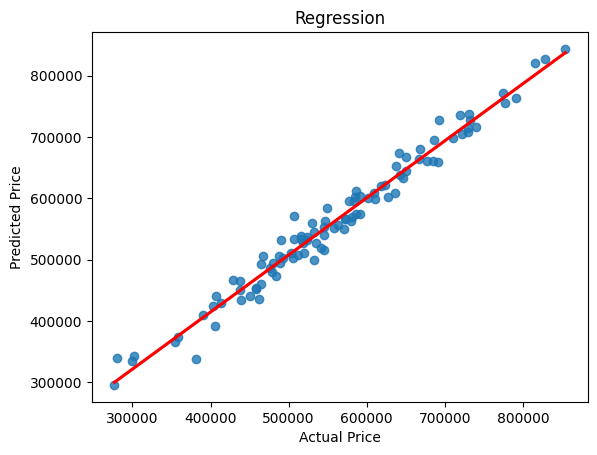

In [131]:
sns.regplot(x=y_test, y=y_pred, line_kws={'color': 'red'}, ci=None)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Regression")

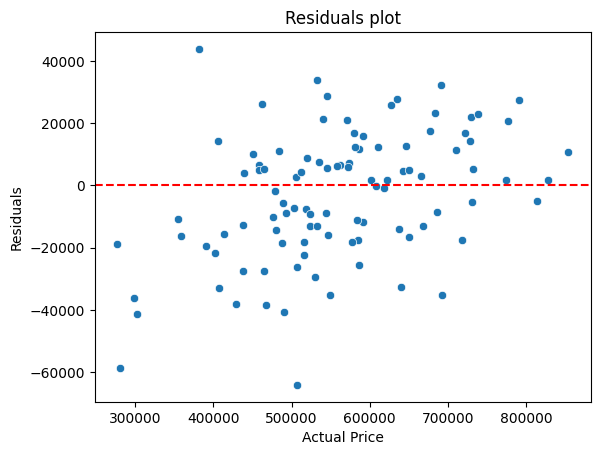

In [127]:
residuals = y_test - y_pred
sns.scatterplot(x=y_test, y=residuals)
plt.xlabel("Actual Price")
plt.ylabel("Residuals")
plt.title("Residuals plot")
plt.axhline(y=0, color='red', linestyle='--')